### **Quick introduction to jupyter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* Code cells will print their output, including images, below the cell. Running it again deletes the previous output, so be careful if you want to save some results.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells.
* A useful debug tool is the console. You can right-click anywhere in the notebook and select "New console for notebook". This opens a python console which shares the environment with the notebook, which let's you easily print variables or test commands.

### **Setup**

In [106]:
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2
# Plot figures "inline" with other output
%matplotlib inline

# Import modules, classes, functions
from matplotlib import pyplot as plt
import numpy as np

from utils import loadDataset, splitData, plotProgressNetwork, plotProgressOCR, \
    plotResultsDots, plotIsolines, plotConfusionMatrixOCR, plotResultsDotsGradient
from evalFunctions import calcAccuracy, calcConfusionMatrix

# Configure nice figures
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(8, 5)

### ***! IMPORTANT NOTE !***

Your implementation should only use the `numpy` (`np`) module. The `numpy` module provides all the functionality you need for this assignment and makes it easier debuging your code. No other modules, e.g. `scikit-learn` or `scipy` among others, are allowed and solutions using modules other than `numpy` will be sent for re-submission. You can find everything you need about `numpy` in the official [documentation](https://numpy.org/doc/stable/).

---
### **1. Single layer neural network**

In this and the next notebook, you will implement and train two types of neural networks. We begin with a single layer network in this notebook, where the predicted classes are based on linear combinations of the input features. The single layer network can only learn decision boundaries. The next notebook introduces the multi-layer network, which is a general function approximator and therefore can learn any function given enough resourses.

Training a network consist of three main steps:
1. Forward pass - Comupte predicted outputs based on inputs features.
2. Backward pass - Compute weight gradients.
3. Update - Use gradients and hyperparameters to update weights.

Begin by implementing these three functions.

#### **1.1 Implementing the forward pass**

In the following function you will implement the forward pass, i.e. take the input features `X`, weights `W`, and biases `B`, and compute the predicted outputs of the network. Optionally, you can choose to also implement the forward pass when using *tanh* activation function in the output layer. This does not make the classifier non-linear, but it can help speed up the training.

Note: In `numpy`, the multiplication symbol `*` means element-wise multiplication. Matrix multiplication is done using the `@` symbol, for example `A @ B` where `A` and `B` are compatible matrices. Transposing a `numpy` matrix is done with `A.T`.

In [247]:
def forward(X, W, B, useTanhOutput=False):
    """Forward pass of single layer network.

    Performs one forward pass of the single layer network, i.e
    it takes the input data and calculates the output for each sample.

    Args:
        X (array): Input samples.
        W (array): Neural network weights.
        B (array): Neural network biases.

    Returns:
        Y (array): Output for each sample and class.
        L (array): Resulting label of each sample.
    """
    
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    
    Y = W@X.T + B
        
    # ============================================
        
    # Calculate labels
    L = np.argmax(Y.T, axis=1)
    
    return Y.T, L

#### **1.2 Implementing the backward pass**

Now, using the predicted outputs `Y` from the forward pass, compute the gradients of the weights and biases. To do this you must use the target outputs `D`. If you print `D` you will see that it contains values that are ±0.99. This might seem strange at first, where ±1 would be a more intuitive choice. However, this is a trick to prevent the weights of the network from becomming too large when using the optional *tanh* activation in the output layer. Since *tanh* never reach ±1 (only in the limit at ±Inf) it would push the weight to very large values in order to reach closer and closer to those limits. This is undesirable, so instead we choose the targets ±0.99, which only require the inputs to *tanh* to be approximately ±2.6, allowing much smaller weights and therefore a more stable classifier. None of this should matter for your implementation of the backward pass, but it is nonetheless good to understand the data you are working with.

In [248]:
def backward(W, B, X, Y, D, useTanhOutput=False):
    """Compute the gradients for network weights and biases

    Args:
        W (array): Current values of the network weights.
        B (array): Current values of the network biases.
        X (array): Training samples.
        Y (array): Predicted outputs.
        D (array): Target outputs.
        
        useTanhOutput (bool) (optional):
            True  - Network uses tanh activation on output layer
            False - Network uses linear (no) activation on output layer
        
    Returns:
        GradW (array): Gradients with respect to W
        GradB (array): Gradients with respect to B
    """
    
    N = Y.shape[0]
    
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
        
    # Calculate gradients
    GradW = Y.T@X / N
    GradB = np.sum(Y, axis=0, keepdims=True).T / N
    
    # ============================================
    
    return GradW, GradB

#### **1.3 Implementing the weight update**

Finally, after computing the gradients using the `backward` function, update and return the new weights and biases. While there are many advanced updated methods, we will only look at the most basic in this assignment,  unmodified gradient descent. Implement the following function, which should be very short.

In [150]:
def update(W, B, GradW, GradB, params):
    """Update weights and biases using computed gradients.

    Args:
        W (array): Current values of the network weights.
        B (array): Current values of the network biases.
        GradW (array): Gradients with respect to W.
        GradB (array): Gradients with respect to B.
        
        params (dict):
            - learningRate: Scale factor for update step.
        
    Returns:
        W (array): Updated weights.
        B (array): Updated biases.
    """
    
    LR = params["learningRate"]
    
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    W = W - LR * GradW
    B = B - LR * GradB
    
    # ============================================
    
    return W, B
    

#### **1.4 The training function**

In order to train the network using your implementation of `forward`, `backward`, and `update`, we have prepared the following function for you. This takes your training data and initial weights, sets up all required variables, then trains the network for the specified number of epochs while tracking metrics and plotting the training progress. Read the function and make sure you understand how your own implementations are used.

In [207]:
def trainSingleLayer(XTrain, DTrain, XTest, DTest, W0, B0, params, plotProgress=True):
    """Trains a single-layer network.

    Args:
        XTrain (array): Training samples.
        DTrain (array): Training network target values.
        XTest (array): Test samples.
        DTest (array): Test network target values.
        W0 (array): Initial values of the network weights.
        B0 (array): Initial values of the network biases.
        
        params (dict): Dictionary containing:
            epochs (int): Number of training steps.
            learningRate (float): Size of a training step.
            useTanhOutput (bool): Determines if output layer should use tanh activation.

    Returns:
        W (array): Weights after training.
        B (array): Biases after training.
        metrics (dict): Losses and accuracies for training and test data.
    """

    # Initialize variables
    metrics = {keys:np.zeros(params["epochs"]+1) for keys in ["lossTrain", "lossTest", "accTrain", "accTest"]}
    
    if "useTanhOutput" not in params:
        params["useTanhOutput"] = False

    nTrain = XTrain.shape[0]
    nTest  = XTest.shape[0]

    # Set initial weights
    W = W0
    B = B0

    # Get class labels
    LTrain = np.argmax(DTrain, axis=1)
    LTest  = np.argmax(DTest , axis=1)

    # Calculate initial metrics
    YTrain, LTrainPred = forward(XTrain, W, B, params["useTanhOutput"])
    YTest , LTestPred  = forward(XTest , W, B, params["useTanhOutput"])
    
    # Including the initial metrics makes the progress plots worse, set nan to exclude
    metrics["lossTrain"][0] = np.nan #((YTrain - DTrain)**2).mean()
    metrics["lossTest"][0]  = np.nan #((YTest  - DTest )**2).mean()
    metrics["accTrain"][0]  = np.nan #(LTrainPred == LTrain).mean()
    metrics["accTest"][0]   = np.nan #(LTestPred  == LTest ).mean()

    # Create figure for plotting progress
    if W0.shape[0] < 64:
        fig = plt.figure(figsize=(20,8), tight_layout=True)
    else:
        fig = plt.figure(figsize=(20,8), constrained_layout=True)

    # Training loop
    for n in range(1, params["epochs"]+1):
        
        # --------------------------------------------
        # === This is the important part =============
        # === where your code is applied =============
        # --------------------------------------------
        
        # Compute gradients...
        GradW, GradB = backward(W, B, XTrain, YTrain, DTrain, params["useTanhOutput"])
        # ... and update weights
        W, B = update(W, B, GradW, GradB, params)
        
        # ============================================
        
        # Evaluate errors
        YTrain, LTrainPred = forward(XTrain, W, B, params["useTanhOutput"])
        YTest , LTestPred  = forward(XTest , W, B, params["useTanhOutput"])
        metrics["lossTrain"][n] = ((YTrain - DTrain)**2).mean()
        metrics["lossTest"][n]  = ((YTest  - DTest )**2).mean()
        metrics["accTrain"][n]  = (LTrainPred == LTrain).mean()
        metrics["accTest"][n]   = (LTestPred  == LTest ).mean()

        # Plot progress
        if (plotProgress and not n % (params["epochs"] // 25)) or n == params["epochs"]:
            if W0.shape[0] < 64:
                plotProgressNetwork(fig, W.T, B.T, metrics, n=n, cmap='coolwarm')
            else:
                plotProgressOCR(fig, W, metrics, n=n, cmap='coolwarm_r')

    return W, B, metrics

#### **1.5. Test your implementation**

It is time to test your implementation by training the a network on the first dataset. You will begin by running all the required code manually, so you will see and understand each part of the process. Later, we will define a function that does all these steps for you. But for now, run the following cell to load the data and split it into training and test sets.

In [255]:
# Select and load dataset
datasetNr = 1
X, D, L = loadDataset(datasetNr)

# Split data into training and test sets
XTrain, DTrain, LTrain, XTest, DTest, LTest = splitData(X, D, L, 0.15)

One important aspect of data preprocessing is data normalization. Often, normalizing the data can turn a very difficult dataset into a simple one, simply by ensuring that the data is similarly distributed in each feature dimension. This becomes much more important as we increase the complexity of the data, so you might not see much difference in the first three datasets. However, in the OCR data this will be much more important, and even more so in the next assignement on deep learning.

For now, we define a function that normalizes each feature to have zero mean and unit standard deviation

$$ \large m = \frac{1}{N} \sum_i^N X_i \quad \quad \quad \large s = \sqrt{ \frac{1}{N} \sum_i^N \left( X_i - m \right)^2 }$$

$$ \large X_\mathrm{norm} = \frac{X - m}{s}$$

In [226]:
def normalize(X):
    # Compute mean and std
    m = X.mean(axis=0)
    s = X.std(axis=0)
    # Prevent division by 0 is feature has no variance
    s[s == 0] = 1
    # Return normalized data
    return (X - m) / s

Run this code to normalize the training and test data. These are the datasets you will input to the training function.

In [256]:
XTrainNorm = normalize(XTrain)
XTestNorm  = normalize(XTest)

Now you should initialize your weights and biases. It is up to you to figure out the correct shapes of `W0` and `B0` based on the number of inputs and number of output classes. You also need to experiment with different initialization strategies. For example, should the weights be all zeros, all ones, random, and in that case what distribution and magnitude? The only requirement we give you is that `W0` and `B0` are numpy arrays, to make the rest of the code work as expected.

*Hint: The question how to initialize the network parameters is not new, and many clever researchers have tried to come up with automatic solutions. If you are interested you can search for "Xavier initialization" and try to implement it.*

In [257]:
# --------------------------------------------
# === Your code here ========================= 
# --------------------------------------------
nInputs  = X.shape[1]
nClasses = len(set(L))

scale = 1 / max(1., (nInputs+nClasses)/2.)
limit = np.sqrt(3.0 * scale)
W0 = np.random.uniform(-limit, limit, size=(nClasses, nInputs))
B0 = np.random.rand(nClasses, 1)

print("W: ", W0.shape)
print("B: ", B0.shape)
# ============================================

W:  (2, 2)
B:  (2, 1)


Now set the training parameters in the `params` dictionary. Later, you will add some more parameters, but for this first test the number of `epochs` and the `learningRate` is sufficient. Then run the training and observe how the losses, accuracies, and network weights change as the training progresses.

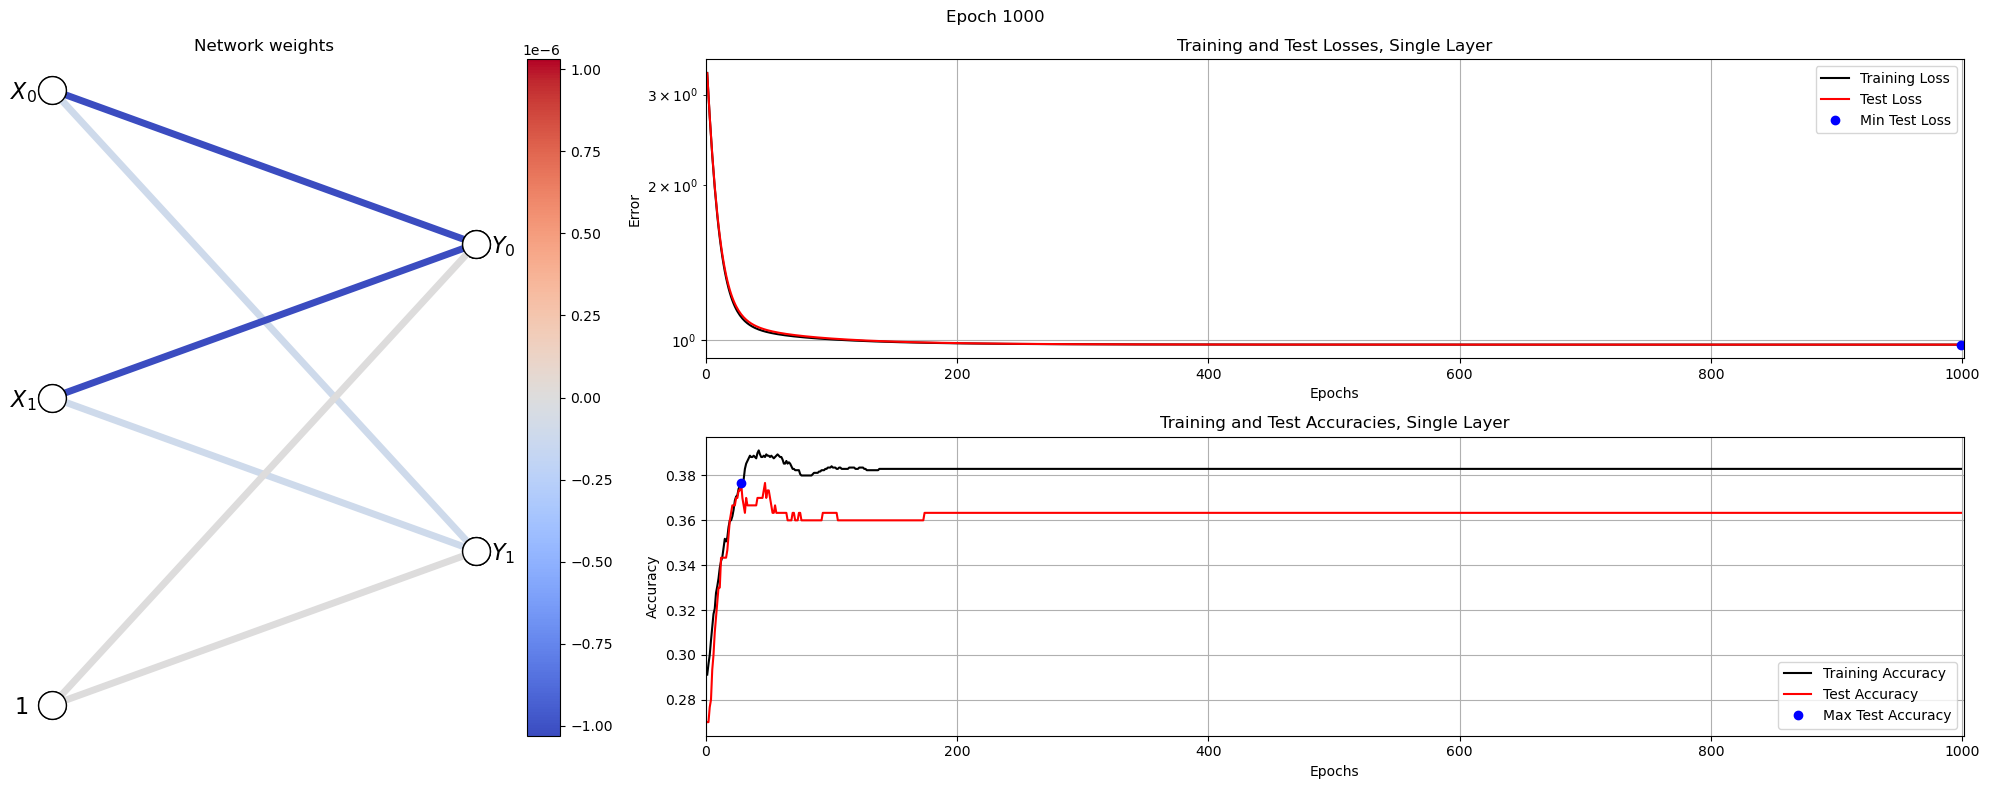

In [258]:
params = {"epochs": 1000, "learningRate": 0.05}
W, B, metrics = trainSingleLayer(XTrainNorm, DTrain, XTestNorm, DTest, W0, B0, params, plotProgress=True)

Now use the trained weights to predict the output labels. To investigate overfitting, we predict both the training and test labels.

In [244]:
LPredTrain = forward(XTrainNorm, W, B)[1]
LPredTest  = forward(XTestNorm , W, B)[1]

Use the labels to get accuracies and the confusion matrix.

In [245]:
# Calculate the training and test accuracy
accTrain = calcAccuracy(LPredTrain, LTrain)
accTest = calcAccuracy(LPredTest, LTest)
print(f'Train accuracy: {accTrain:.4f}')
print(f'Test accuracy: {accTest:.4f}')

# Calculate confunsion matrix of test data
confMatrix = calcConfusionMatrix(LPredTest, LTest)
print("Test data confusion matrix:")
print(confMatrix)

Train accuracy: 0.5176
Test accuracy: 0.5233
Test data confusion matrix:
[[88 15 24]
 [ 0  0  3]
 [16 85 69]]


And finally, plot the results. For the point-cloud datasets we have two different plot options. We recommend that you start with the normal function `plotResultDots`, which shows the predicted class boundaries and will be easiest to interpret. However, if you want to learn more about how the classifiers work, you can also look at the results from `plotResultsDotsGradient` which shows the strength of each class field as a colored gradient. But this is entirely optional, and will also be more interesting in the multi-layer case.

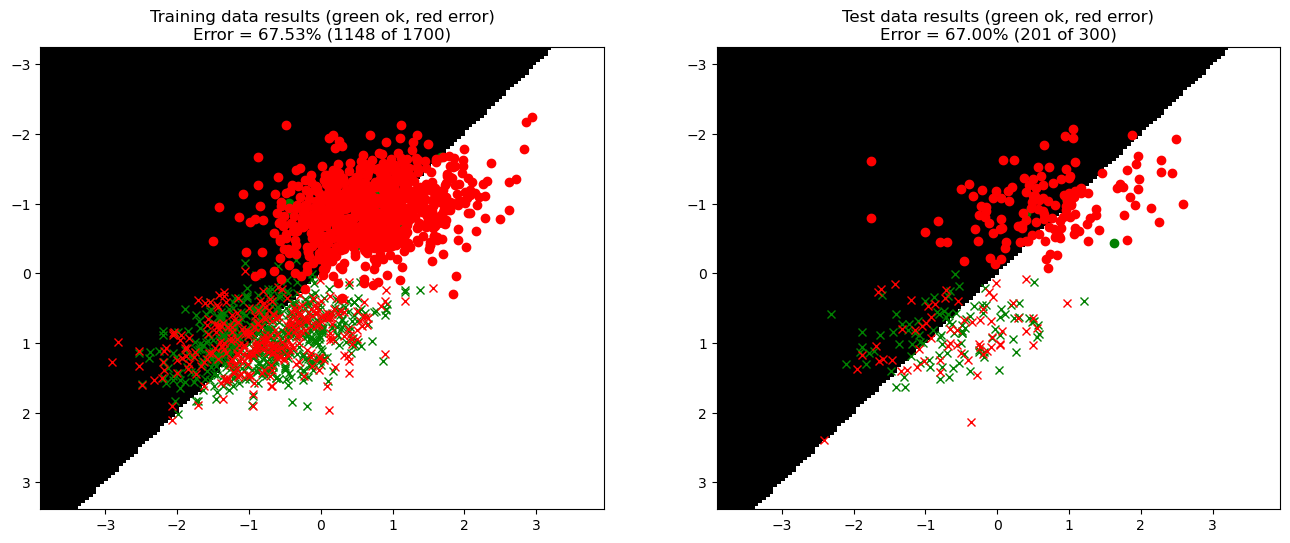

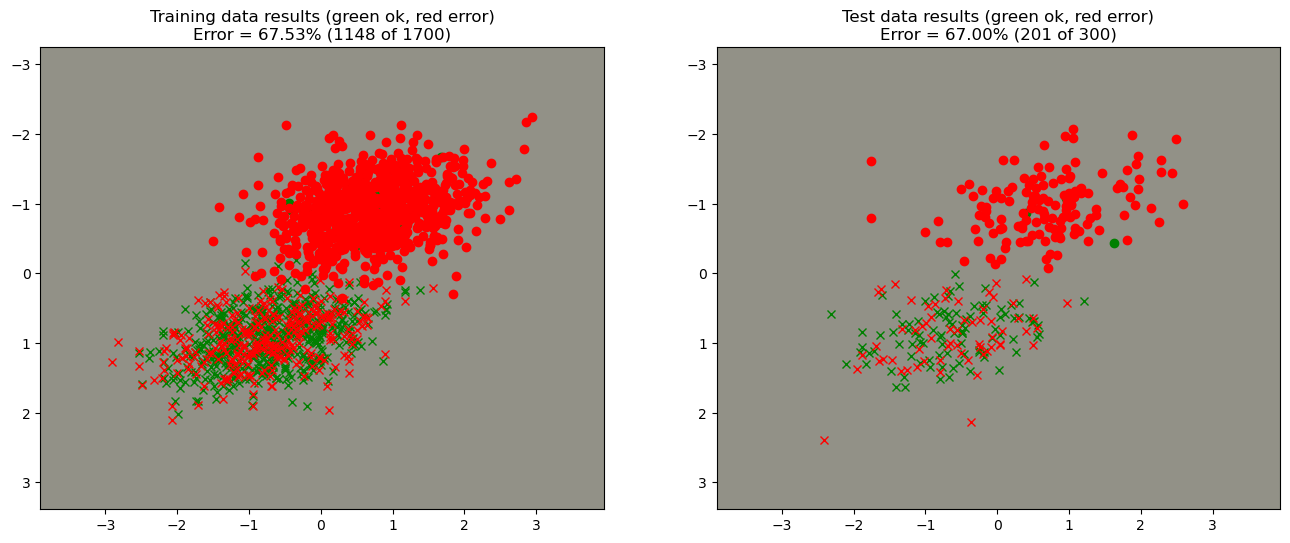

In [261]:
if datasetNr < 4:
    plotResultsDots(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W, B)[1])
    plotResultsDotsGradient(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W, B)[0])
else:
    plotConfusionMatrixOCR(XTest, LTest, LPredTest)

---
### **2 Optimizing each dataset**

The process above is a bit long, since you have to load and normalize data, initailize weights, train the network, measure metrics, and plot the results for each dataset. We can make things a bit easier by defining a function that does most of this for us. In addition to the previous parameters `epochs` and `learningRate`, this function also accepts the parameter `normalize` (True / False) which enables or disables the data normalization. You will use this to answer some questions below. You can also set the optional parameter `useTanhOutput` (True / False) to enable or diable the use of *tanh* activation in the output layer, if you have implemented it in the previous functions.

In [ ]:
def trainSingleLayerOnDataset(datasetNr, testSplit, W0, B0, params):
    """Train a single layer network on a specific dataset.

    Ags:
        datasetNr (int): ID of dataset to use
        testSplit (float): Fraction of data reserved for testing.
        W0 (array): Initial values of the network weights.
        B0 (array): Initial values of the network biases.
        
        params (dict): Dictionary containing:
            epochs (int): Number of training steps.
            learningRate (float): Size of a training step.
            normalize (bool): Should data be normalized?
            useTanhOutput (bool): Should tanh activation be used for outputs?
    """

    # Load data and split into training and test sets
    X, D, L = loadDataset(datasetNr)
    D = np.round(D)
    XTrain, DTrain, LTrain, XTest, DTest, LTest = splitData(X, D, L, testSplit)

    if "normalize" in params and params["normalize"]:
        XTrainNorm = normalize(XTrain)
        XTestNorm  = normalize(XTest)
    else:
        XTrainNorm = XTrain
        XTestNorm  = XTest
    
    # Train network
    W, B, metrics = trainSingleLayer(XTrainNorm, DTrain, XTestNorm, DTest, W0, B0, params, plotProgress=True)

    # Predict classes on test set
    LPredTrain = forward(XTrainNorm, W, B)[1]
    LPredTest = forward(XTestNorm, W, B)[1]
    
    # Compute metrics
    accTrain = calcAccuracy(LPredTrain, LTrain)
    accTest = calcAccuracy(LPredTest, LTest)
    confMatrix = calcConfusionMatrix(LPredTest, LTest)
    
    # Display results
    print(f'Train accuracy: {accTrain:.4f}')
    print(f'Test accuracy: {accTest:.4f}')
    print("Test data confusion matrix:")
    print(confMatrix)

    if datasetNr < 4:
        # Switch between these two functions to see another way to visualize the network output.
        plotResultsDots(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W, B)[1])
        #plotResultsDotsGradient(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W, B)[0])
    else:
        plotConfusionMatrixOCR(XTest, LTest, LPredTest)

#### **2.1 Optimizing dataset 1**

The first dataset is very simple and you should not have any trouble reaching convergence in this case.

In [ ]:
# --------------------------------------------
# === Your code here ========================= 
# --------------------------------------------
nInputs  = ???
nClasses = ???

W0 = ???
B0 = ???

params = {"epochs": ???, "learningRate": ???, "normalize": False, "useTanOutput": False}
# ============================================

trainSingleLayerOnDataset(1, 0.15, W0, B0, params)

#### **<span style="color:red">Question 1:</span>**

Optimize the training until you reach at least 98% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**

\[ Your answers here \]

#### **<span style="color:red">Question 2:</span>**

When you have acheived a stable training, run it once with and once without normalization and observe the bias weights in the network plot. Explain your observations.

#### **<span style="color:green">Answer:</span>**

\[ Your answers here \]

#### **2.2 Optimizing dataset 2**

In [ ]:
# --------------------------------------------
# === Your code here ========================= 
# --------------------------------------------

nInputs  = ???
nClasses = ???

W0 = ???
B0 = ???

params = {"epochs": ???, "learningRate": ???, "normalize": False, "useTanOutput": False}
# ============================================

trainSingleLayerOnDataset(2, 0.15, W0, B0, params)

#### **2.3 Optimizing dataset 3**

In [ ]:
# --------------------------------------------
# === Your code here ========================= 
# --------------------------------------------
nInputs  = ???
nClasses = ???

W0 = ???
B0 = ???

params = {"epochs": ???, "learningRate": ???, "normalize": False, "useTanOutput": False}
# ============================================

trainSingleLayerOnDataset(3, 0.15, W0, B0, params)

#### **2.4 Optimizing dataset 4**

Dataset 4 contains OCR-data and is therefore more complicated than the previous three. We therefore recommend that you enable normalization to make the problem a bit easier to solve. We also change the network visualization. Since each weight now corresponds to a pixel in the 8x8 images, we can plot the weights connected to each output class as images as well, which in some sense shows which areas in the images are important to recognize different numbers. It might be a bit difficult to see at first, but somtimes it is possible to see hints of the numbers in these weight illustrations.

In [ ]:
# --------------------------------------------
# === Your code here ========================= 
# --------------------------------------------
nInputs  = ???
nClasses = ???

W0 = ???
B0 = ???

params = {"epochs": ???, "learningRate": ???, "normalize": False, "useTanOutput": False}
# ============================================

trainSingleLayerOnDataset(4, 0.15, W0, B0, params)

#### **<span style="color:red">Question 3:</span>**

You should be able to get surprisingly high accuracy on this dataset using the single-layer network. Explain how this is possible.

*Hint: Think of the number of input and output dimensions of the problem.*

#### **<span style="color:green">Answer:</span>**

\[ Your answers here \]

---
### **3. Optional tasks**
Here is an optional task that you can try if you are interested to learn more.

#### **3.1 Tanh output activations**
Implement *tanh* activation in the output layer and re-train the networks in section 2. Do you see any differences in the convergence speed or the decision boundaries? It will probably be more interesting to use the `plotResultsDotsGradient` function for this experiment (see comment at the end of `trainSingleLayerOnDataset`).
